In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import StepLR

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data loading and processing

In [2]:
#load csv files to pandas dataframe
train_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)

In [3]:
#the last column is the data label described as category from 0 to 4
#so we can use it as a target
y_df = train_df.iloc[:, -1]
y_df = y_df.astype('int')
y_df.head()

0    0
1    0
2    0
3    0
4    0
Name: 187, dtype: int64

In [4]:
#the rest are the ecg datapoints so we use them as features
X_df = train_df.iloc[:, :-1]
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#convert all feautures to float type
X_df = X_df.astype('float')
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#we actually dont need to one hot encode the target since we are using cross entropy loss and it runs more efficiently when we pass in the target as indices
#print out the unique values in the target
unique, counts = np.unique(y_df, return_counts=True)
print(f'unique values: {unique}')
print(f'counts: {counts}')

unique values: [0 1 2 3 4]
counts: [72471  2223  5788   641  6431]


In [7]:
#make a dictionary to map the target indices to class names
class_names = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

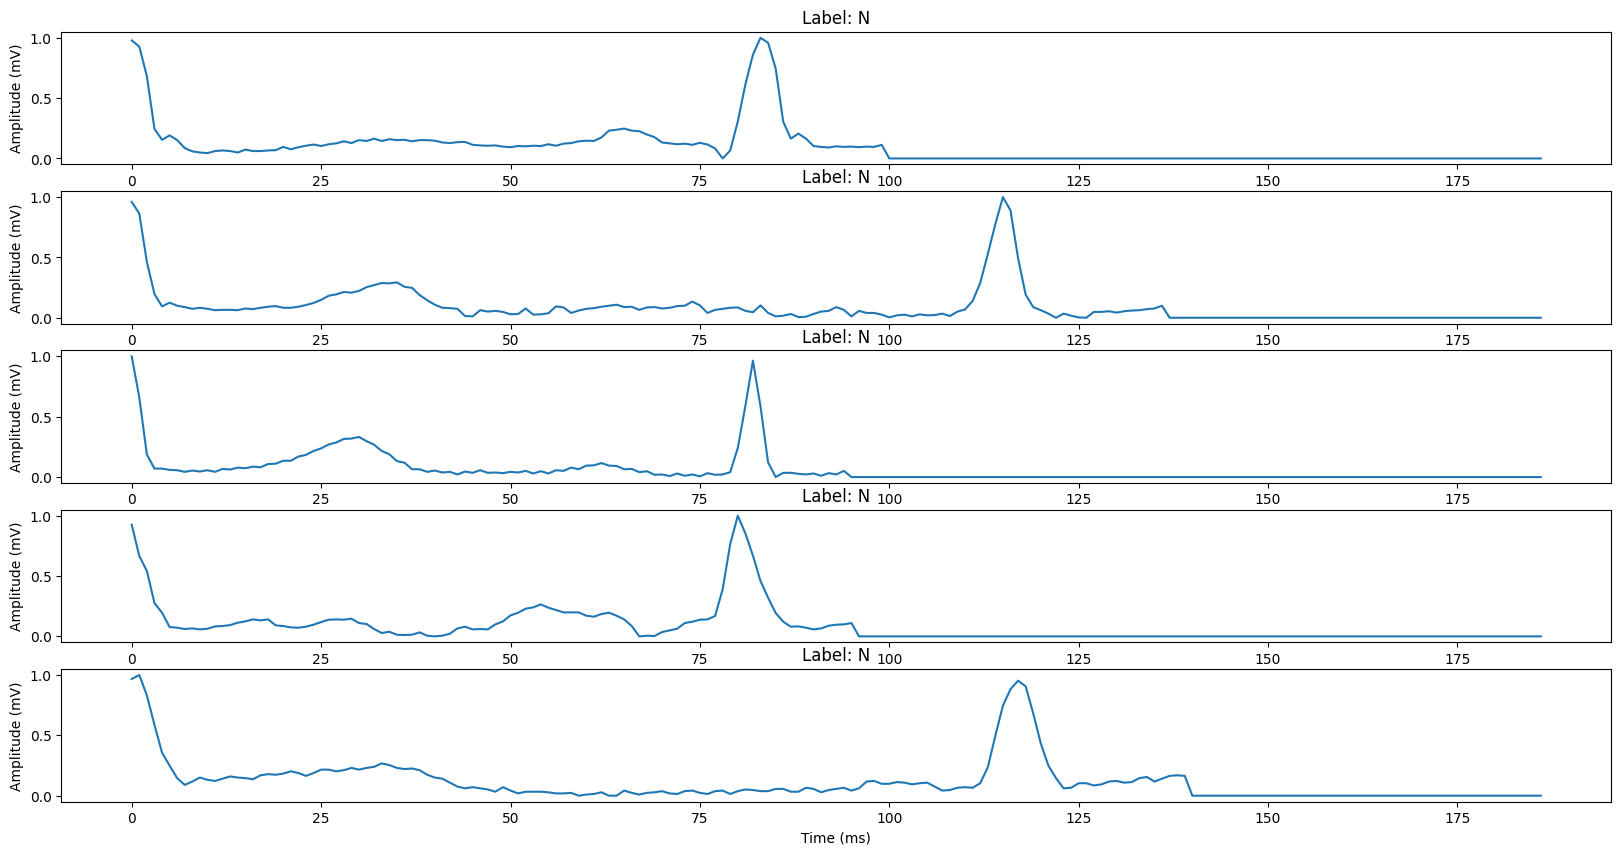

In [8]:
#plot the first 5 ecg signals in the dataset and their corresponding labels 
fig, ax = plt.subplots(5, 1, figsize=(20, 10))
for i in range(5):
    ax[i].plot(X_df.iloc[i, :])
    ax[i].set_title(f'Label: {class_names[y_df[i]]}')
    ax[i].set_xlabel('Time (ms)')
    ax[i].set_ylabel('Amplitude (mV)')

In [9]:
#the input dims are 187 and the output dims are 5
#we want the input to be (batch_size, 1, 187) and the output to be (batch_size, 5) because the input has one channel and the output has 5 classes
X_np = X_df.to_numpy()
X_np.shape

(87554, 187)

In [10]:
#we want to add a channel dimension to the input
X_np = X_np.reshape(-1, 1, 187)
X_np.shape

(87554, 1, 187)

In [11]:
#do the same for the target
y_np = y_df.to_numpy()
y_np.shape

(87554,)

In [12]:
y_np = y_np.reshape(-1, 1)
y_np.shape

(87554, 1)

# Data normalization

In [13]:
#perfect, we now have the input and target in the correct shape
X_mean = X_np.mean()
X_std = X_np.std()
X_max = X_np.max()
X_min = X_np.min()
print(f'mean before normalization: {X_mean}')
print(f'std: {X_std}')
print(f'max: {X_max}')

mean before normalization: 0.17428295254906354
std: 0.22632738719052128
max: 1.0


In [14]:
#we need to subtract the mean from the data
X_norm = X_np - X_mean
#then multiply by 1/std to make the std = 1
X_norm *= 1/X_std

In [15]:
print(X_norm.shape)
print(f'new mean is {X_norm.mean()}')
print(f'new std is {X_norm.std()}')

(87554, 1, 187)
new mean is 1.5088439287128576e-15
new std is 1.0000000000000004


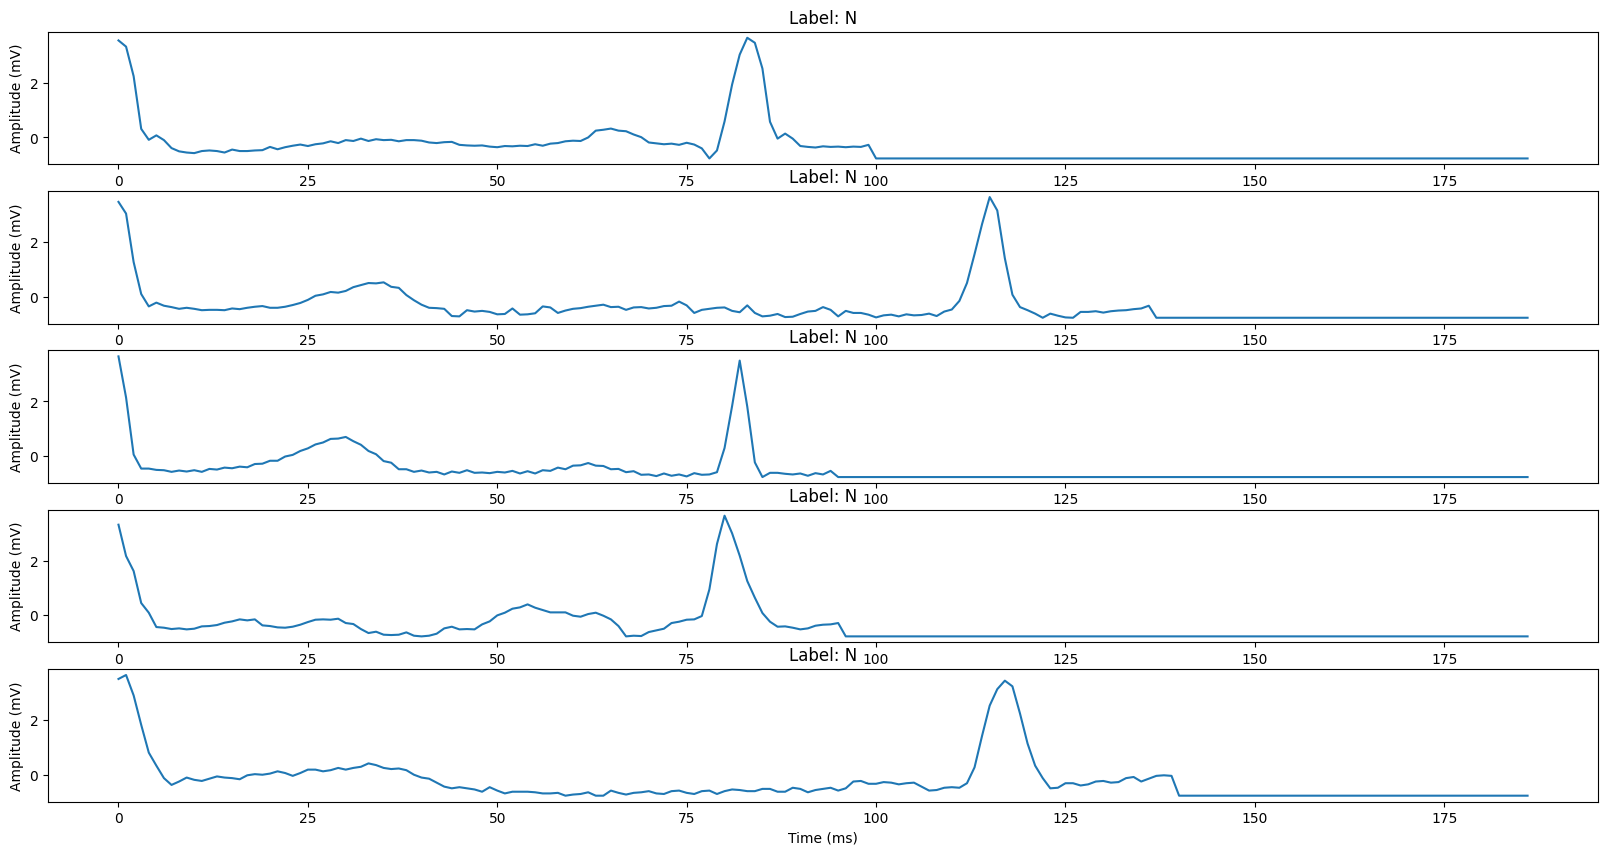

In [16]:
#now plot the normalized data
fig, ax = plt.subplots(5, 1, figsize=(20, 10))
for i in range(5):
    ax[i].plot(X_norm[i, 0, :])
    ax[i].set_title(f'Label: {class_names[y_df[i]]}')
    ax[i].set_xlabel('Time (ms)')
    ax[i].set_ylabel('Amplitude (mV)')

Text(0, 0.5, 'Amplitude (mV)')

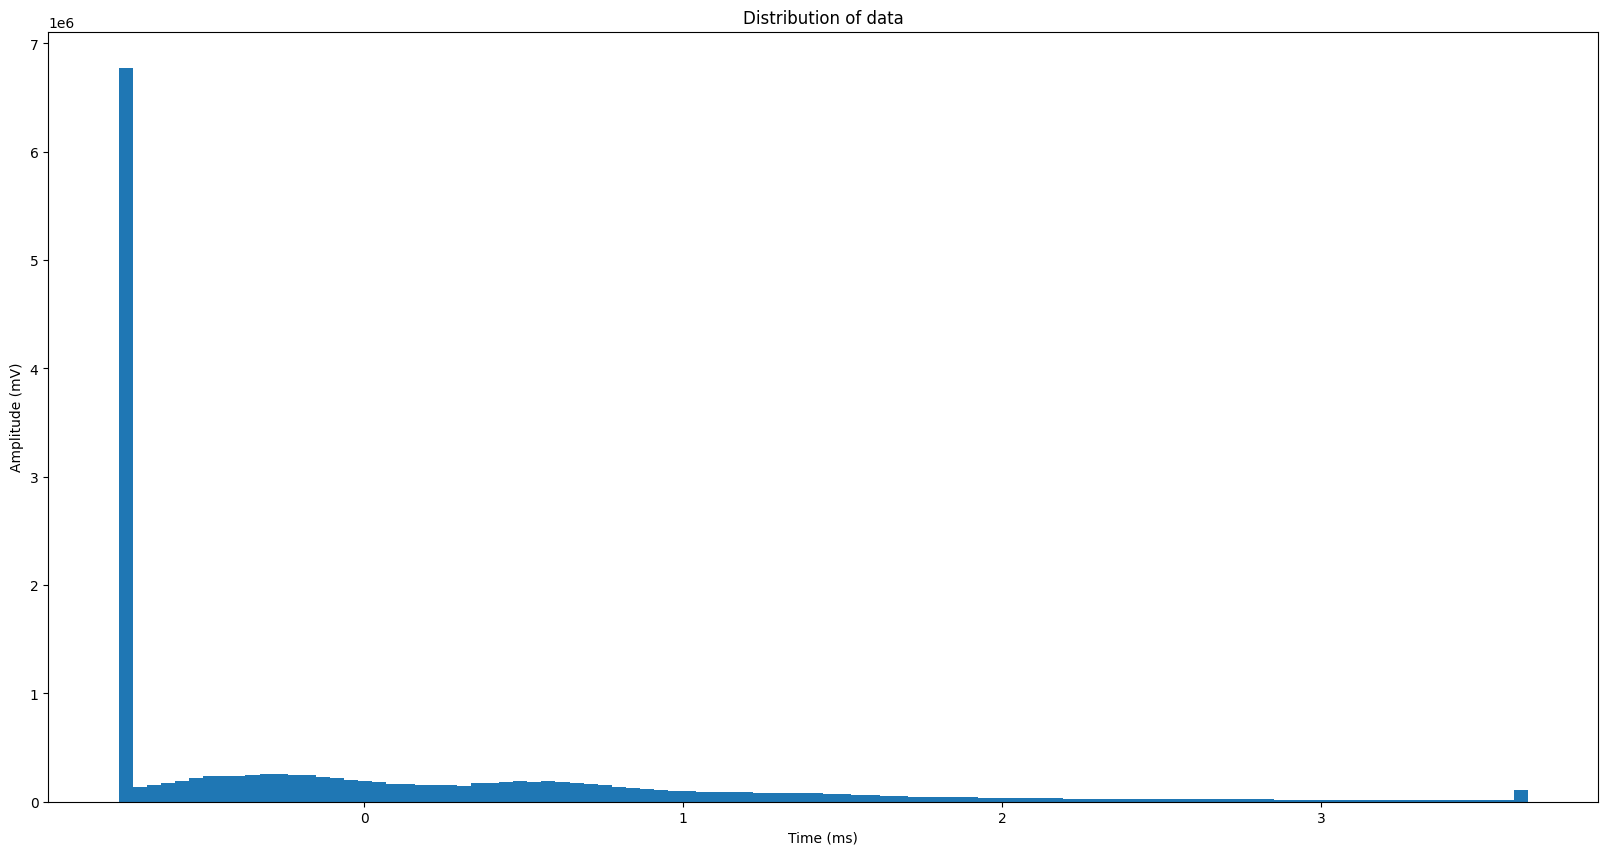

In [17]:
#now plot the distribution of data 
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.hist(X_norm.flatten(), bins=100)
ax.set_title(f'Distribution of data')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (mV)')

In [18]:
X_norm.shape #representing the input data as a sequence of 187 points

(87554, 1, 187)

In [19]:
y_np.shape #representing the target as indices 0 to 4

(87554, 1)

# Saving the normalized variables

In [20]:
#saving the normalized data to a csv file
np.savetxt('X_norm.csv', X_norm.squeeze(), delimiter=',')
np.savetxt('y_np.csv', y_np, delimiter=',')
# np.loadtxt('X_norm.csv', delimiter=',').shape

# Loading the normalized variables from disk

In [21]:
X_norm = np.loadtxt('X_norm.csv', delimiter=',').reshape(-1, 1, 187)
y_np = np.loadtxt('y_np.csv', delimiter=',').reshape(-1, 1)

In [22]:
print(X_norm.shape)
print(y_np.shape)

(87554, 1, 187)
(87554, 1)


In [23]:
#change y_np data type to int
y_np = y_np.astype('int')
y_np.dtype

dtype('int64')

## We split the data into training and validation sets using scikit-learn

In [24]:
#shuffle the data and split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_norm, y_np, test_size=0.2, shuffle=True)


### Now we check for class imbalance

In [25]:
#print the frequency of each class in the train and validation sets
print(f'Frequency of each class in the train set')
unique, counts = np.unique(y_train, return_counts=True)
for i in range(len(unique)):
    print(f'{class_names[unique[i]]}: {counts[i]}')

print(f'Frequency of each class in the validation set')
unique, counts = np.unique(y_val, return_counts=True)
for i in range(len(unique)):
    print(f'{class_names[unique[i]]}: {counts[i]}')

Frequency of each class in the train set
N: 57901
S: 1789
V: 4654
F: 505
Q: 5194
Frequency of each class in the validation set
N: 14570
S: 434
V: 1134
F: 136
Q: 1237


### We define a hyper-parameters dictionary

In [26]:
hyper_params = {'bs': 1024,
                                'lr': 1e-3,
                                'lr_decay': 0.3,
                                'epochs':50,
                                }

In [27]:
#pytorch dataset and dataloader
train_ds = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_ds = torch.utils.data.TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())

In [28]:
len(train_ds), len(val_ds)

(70043, 17511)

### We compute the weight of each class by inverting their distribution and normalizing it

In [29]:
#the class distribution is not uniform so we have to define weights for each class
class_dist = np.unique(y_train, return_counts=True)[1] #index 1 returns the counts
class_dist = class_dist/np.sum(class_dist) #normalize to get 0-1 values
# normalize the weights
weights = 1/class_dist #invert to compensate for class distribution imbalance
weights = weights/weights.sum() #normalize to get values 0-1
weights, class_names

(array([0.00582719, 0.18859711, 0.07249683, 0.66811926, 0.06495961]),
 {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'})

### We assign each example in the training set the weight we computed in the above cell

In [30]:
#get weights for each example in the dataset
data_weights = np.zeros(y_train.shape[0]) #shape (m, )
for i in range(y_train.shape[0]): #for each example we assign the corresponding weight
    data_weights[i] = weights[y_train[i, 0]]
data_weights[:10]

array([0.00582719, 0.07249683, 0.00582719, 0.18859711, 0.00582719,
       0.18859711, 0.00582719, 0.00582719, 0.00582719, 0.07249683])

### Then we pass the weights to the WeightedRandomSampler to sample according to the normalized weights

In [31]:
#data loader - we use the random weights sampler to balance the classes
train_dl = DataLoader(train_ds, batch_size=hyper_params['bs'], sampler=WeightedRandomSampler(weights=data_weights, num_samples= len(y_train), replacement=True))
val_dl = DataLoader(val_ds, batch_size=hyper_params['bs'])


#### We check the training dataloader for class distributions

In [32]:
#get the class distribution in dataloader
for batch in train_dl:
    print(batch[1].shape)
    unique, counts = np.unique(batch[1], return_counts=True)
    for i in range(len(unique)):
        print(f'{class_names[unique[i]]}: {counts[i]}')
    break

torch.Size([1024, 1])
N: 202
S: 199
V: 207
F: 216
Q: 200


We can see that the distribution is nearly uniform now

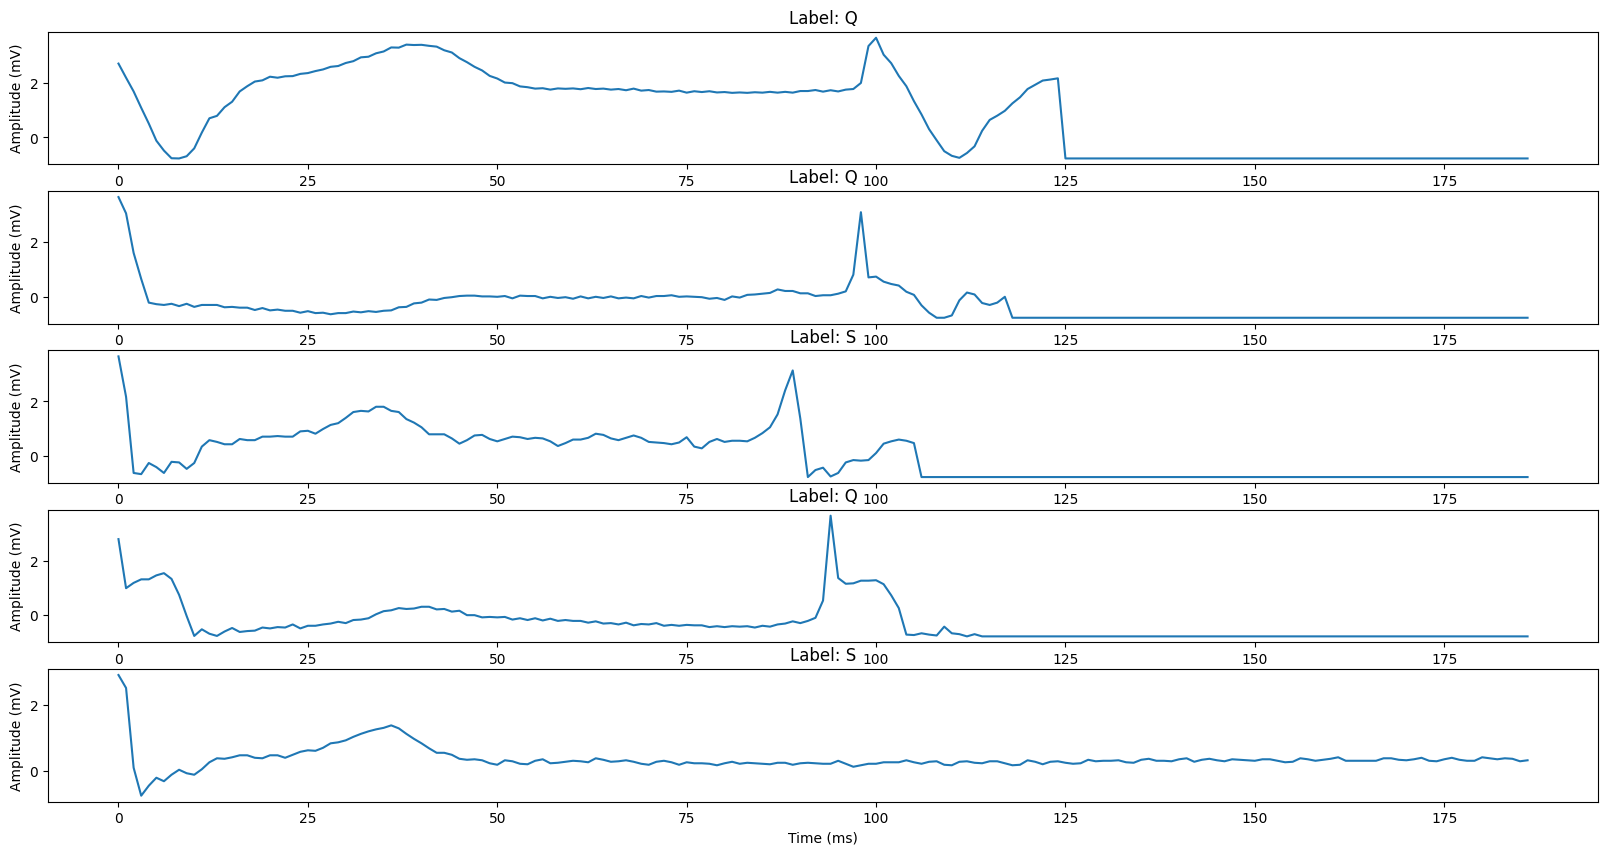

In [33]:
#sample random batch from the train dataloader and plot the first 5 ecg signals in the batch
x, y = next(iter(train_dl))
fig, ax = plt.subplots(5, 1, figsize=(20, 10))
for i in range(5):
    ax[i].plot(x[i, 0, :])
    ax[i].set_title(f'Label: {class_names[y[i].item()]}')
    ax[i].set_xlabel('Time (ms)')
    ax[i].set_ylabel('Amplitude (mV)')

# Network Architecture
### Here, we define a Network-in-network arch to process signals
### instead of using linear layers at the end of the model to classify the signals, we use 1x1 Conv1d layers to capture correlations and global average pooling and reduce the dims
### Also, while experimenting I found out that GELU activation works better than RELU in this case

In [34]:
#make some convolutional blocks to use in the model
def nin_block(in_channels, out_channels, kernel_size, padding, strides):
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernel_size, strides, padding),
        nn.BatchNorm1d(out_channels),
        nn.GELU(),
        nn.Conv1d(out_channels, out_channels, kernel_size=1), nn.GELU(),
        nn.Conv1d(out_channels, out_channels, kernel_size=1), nn.GELU()
    )

In [35]:
def get_model():
    return nn.Sequential( #input shape: (batch_size, 1, 187)
        nin_block(1, 48, kernel_size=11, strides=4, padding=0), #output shape: (batch_size, 48, 44)
        nn.MaxPool1d(3, stride=2), #output shape: (batch_size, 48, 21)
        nin_block(48, 128, kernel_size=5, strides=1, padding=2), #output shape: (batch_size, 128, 21)
        nn.MaxPool1d(3, stride=2), #output shape: (batch_size, 128, 10)
        nin_block(128, 256, kernel_size=3, strides=1, padding=1), #output shape: (batch_size, 256, 10)
        nn.MaxPool1d(3, stride=2), #output shape: (batch_size, 256, 4)
        nn.Dropout(0.4), 
        #last layers for classification of 5 classes
        nin_block(256, 5, kernel_size=3, strides=1, padding=1), #output shape: (batch_size, 5, 4)
        nn.AdaptiveAvgPool1d(1), #output shape: (batch_size, 5, 1)
        nn.Flatten() #output shape: (batch_size, 5)
    )

In [36]:
model = get_model()

In [37]:
#model size in MB
print(f'Model size: {sum(p.numel() for p in model.parameters() if p.requires_grad)*4/(1024**2)} MB')
#number of trainable parameters
print(f'Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Model size: 1.1599540710449219 MB
Number of trainable parameters: 304075


In [38]:
#find device to run the model on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [39]:
#move the model to the device
model = model.to(device)

In [40]:
class_names

{0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

While experimenting, I found out that if I set some weights to some classes the model performs better.

This way I force the model to learn the classes that it didn't do well on.

In [41]:
#loss function
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 1.1, 2.5, 3, 1], dtype=torch.float, device=device)) #CE loss automatically uses indices as targets

In [42]:
#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['lr'])

In [43]:
#lr_scheduler
lr_scheduler = StepLR(optimizer, step_size=10, gamma=hyper_params['lr_decay'], verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


### Training function

In [44]:
def train(model, criterion, optimizer, train_dl, val_dl, epochs, lr_scheduler: StepLR=None):
    """trains the model for the given number of epochs

    Args:
        model (nn.Module): nn model
        criterion (nn.CELoss): loss function
        optimizer (torch.optim): optimizer
        train_dl (Dataloader): training dataloader
        val_dl (Dataloader): validation dataloader
        epochs (int): number of epochs to train for
        lr_scheduler (StepLR): learning rate scheduler to adjust lr during training
    Returns:
        list of training losses and validation losses, best model parameters, best accuracy
    """
    train_losses = []
    val_losses = []
    best_model_params = deepcopy(model.state_dict())
    best_accuracy = 0.0
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-'*10)
        train_loss = 0
        val_loss = 0
        model.train() #set the model to training mode
        for x, y in train_dl: #x: (batch_size, 1, 187), y: (batch_size, 1)
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x) #the output shape is (batch_size, 5) so it's a distribution over the 5 classes
            loss = criterion(output, y.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*x.size(0)
        train_loss = train_loss/len(train_dl.dataset)
        train_losses.append(train_loss)
        lr_scheduler.step() #update the learning rate every n epochs
        model.eval() #set the model to evaluation mode
        corrects = 0 #in order to calculate accuracy we store the number of correct predictions
        for x, y in val_dl:
            x = x.to(device)
            y = y.to(device)
            output = model(x) #out shape: (batch_size, 5)
            loss = criterion(output, y.squeeze())
            val_loss += loss.item()*x.size(0)
            #calculate the number of correct predictions
            corrects += torch.sum(torch.argmax(output, dim=1) == y.squeeze()).item()
        val_loss = val_loss/len(val_dl.dataset)
        accuracy = corrects/len(val_dl.dataset)
        val_losses.append(val_loss)
        print(f'Train Loss: {train_loss:.4f} \t Val Loss: {val_loss:.4f} \t Val Accuracy: {accuracy:.4f}')
        #if the model performs better on the validation set, save the model parameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_params = deepcopy(model.state_dict())
    print('Finished Training and the best accuracy is: {:.4f}'.format(best_accuracy))
    return train_losses, val_losses, best_model_params, best_accuracy

In [45]:
train_losses, val_losses, best_model_params, best_accuracy = train(model, criterion, optimizer, train_dl, val_dl, hyper_params['epochs'], lr_scheduler)

Epoch 1/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 1.5368 	 Val Loss: 1.4966 	 Val Accuracy: 0.6502
Epoch 2/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 1.2932 	 Val Loss: 1.2701 	 Val Accuracy: 0.5941
Epoch 3/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 1.0745 	 Val Loss: 0.8811 	 Val Accuracy: 0.8089
Epoch 4/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.8502 	 Val Loss: 0.4328 	 Val Accuracy: 0.9416
Epoch 5/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.6361 	 Val Loss: 0.4046 	 Val Accuracy: 0.9391
Epoch 6/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.4546 	 Val Loss: 0.3235 	 Val Accuracy: 0.9669
Epoch 7/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.3344 	 Val Loss: 0.3132 	 Val Accuracy: 0.9515
Epoch 8/50
----------
Adjusting learning rate of group 0 to 1.0000e-0

### The model finishes training with a validation accuracy of 98.6% !

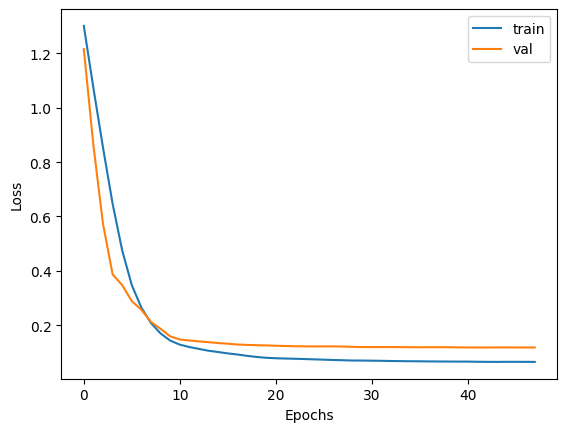

In [46]:
#plot the training and validation losses with smooth lines
plt.plot(np.convolve(train_losses, np.ones(3)/3, mode='valid'), label='train')
plt.plot(np.convolve(val_losses, np.ones(3)/3, mode='valid'), label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [47]:
#load the best model parameters
model.load_state_dict(best_model_params)
#save the model to a file
torch.save(model.state_dict(), f'best_model{best_accuracy:.2f}.pt')

In [48]:
#use this cell to load weights from disk
model = get_model().to(device=device)
model.load_state_dict(torch.load('best_model0.99.pt'))

<All keys matched successfully>

In [49]:
#confusion matrix function
def plot_cm(model, dl, categories, normalize='true'):
    #plot the confusion matrix
    model.eval()
    y_pred = []
    y_true = []
    for x, y in dl:
        x = x.to(device)
        y = y.to(device)
        output = model(x) #out shape: (batch_size, 5)
        y_pred.extend(torch.argmax(output, dim=1).cpu().numpy())
        y_true.extend(y.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    sns.heatmap(cm, annot=True, fmt= '.2f', cmap='Blues', xticklabels=categories.values(), yticklabels=categories.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print(classification_report(y_true, y_pred, target_names=class_names.values()))

### Let's not get too excited, we need to examine the results and make sure the model doesn't trick us by skipping minor classes

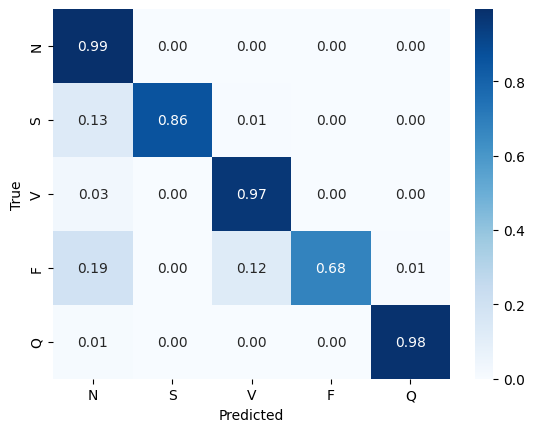

              precision    recall  f1-score   support

           N       0.99      0.99      0.99     14570
           S       0.88      0.86      0.87       434
           V       0.96      0.97      0.96      1134
           F       0.90      0.68      0.77       136
           Q       1.00      0.98      0.99      1237

    accuracy                           0.99     17511
   macro avg       0.95      0.90      0.92     17511
weighted avg       0.99      0.99      0.99     17511



In [50]:
#plot the confusion matrix using the validation set
plot_cm(model, val_dl, class_names)

#### We can see the model does excellently on the validation set

True: F 	 Predicted: N


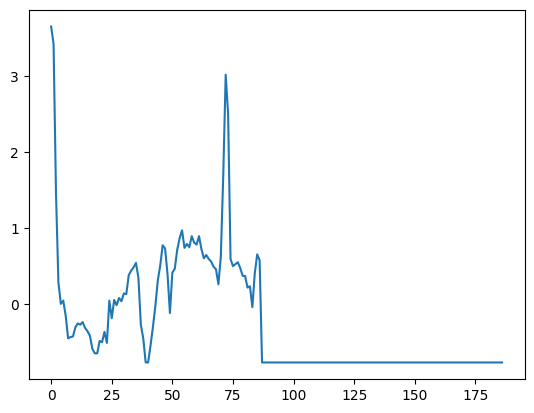

True: S 	 Predicted: N


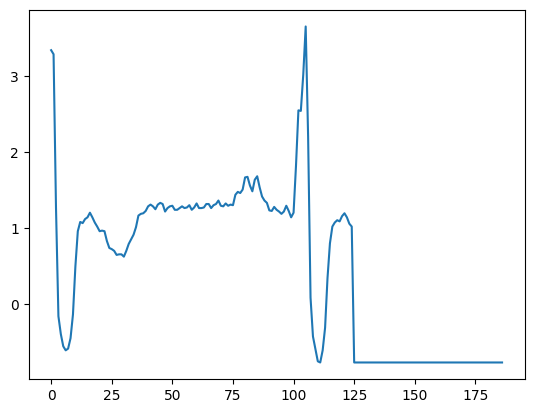

True: V 	 Predicted: N


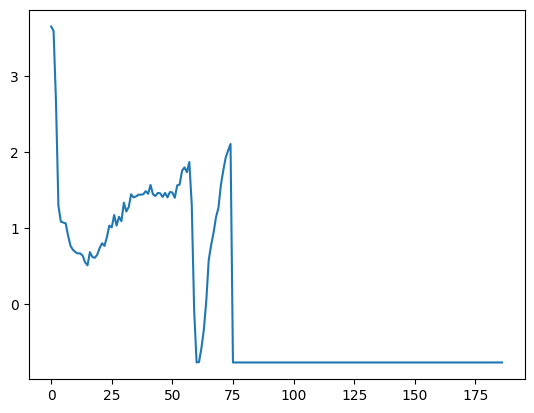

True: N 	 Predicted: V


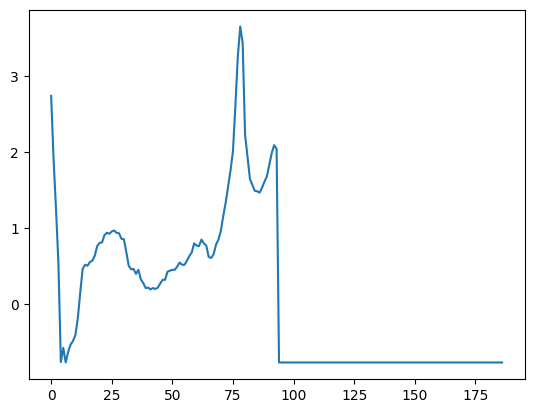

True: F 	 Predicted: V


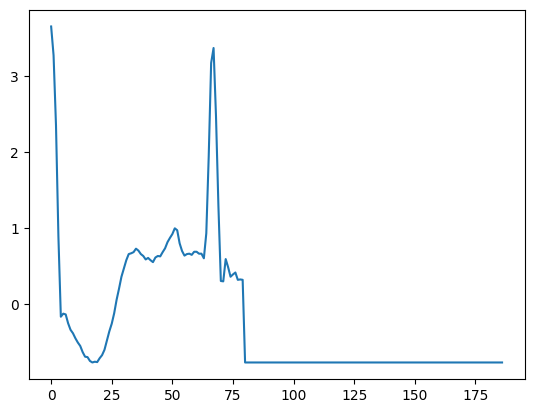

In [51]:
#visualize the predictions the model got wrong
model.eval()
count = 0
for x, y in val_dl:
    x = x.to(device)
    y = y.to(device)
    output = model(x) #out shape: (batch_size, 5)
    y_pred = torch.argmax(output, dim=1)
    for i in range(len(y_pred)):
        if y_pred[i] != y[i] and count < 5:
            print(f'True: {class_names[y[i].item()]} \t Predicted: {class_names[y_pred[i].item()]}')
            plt.plot(x[i, 0, :].cpu().numpy())
            plt.show()
            count += 1

---------------------------------------------------------------------------------------------------------------------------------------------
# this section calculates the model accuracy on **test** data

In [52]:
#this section loads the test data and calculates the accuracy on the test set
test_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv', header=None)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
#the last column is the label
label_df = test_df.iloc[:, -1]
label_df = label_df.astype('int')
label_df.head()

0    0
1    0
2    0
3    0
4    0
Name: 187, dtype: int64

In [54]:
#the rest of the columns are the signal
features_df = test_df.iloc[:, :-1]
features_df = features_df.astype('float32')
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
#convert to numpy arrays
X_test_np = features_df.to_numpy()
y_test_np = label_df.to_numpy()

In [56]:
X_test_np.shape, y_test_np.shape

((21892, 187), (21892,))

In [57]:
#we have to reshape the data to be (batch_size, 1, 187) because that's the shape the model expects
X_test_np = np.reshape(X_test_np, (X_test_np.shape[0], 1, X_test_np.shape[1]))
X_test_np.shape

(21892, 1, 187)

In [58]:
y_test_np = np.reshape(y_test_np, (y_test_np.shape[0], 1))
y_test_np.shape

(21892, 1)

In [59]:
#we have to normalize the data
X_test_np = (X_test_np - X_test_np.mean())/X_test_np.std()
X_test_np[:5, 0, :5]

array([[ 3.664428  ,  2.5926797 , -0.27447614, -0.7691292 , -0.41187975],
       [ 3.2584245 ,  2.70626   ,  1.5856906 ,  0.83864427,  0.8548844 ],
       [ 2.4677598 ,  0.17251123, -0.7691292 , -0.23945646, -0.3179265 ],
       [ 3.664428  ,  3.267255  ,  2.2512314 ,  1.3275739 ,  0.24689431],
       [ 1.7600813 ,  1.0013181 ,  0.2871881 , -0.11451006, -0.7691292 ]],
      dtype=float32)

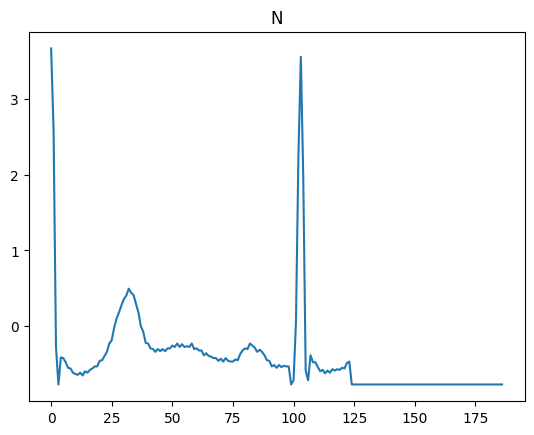

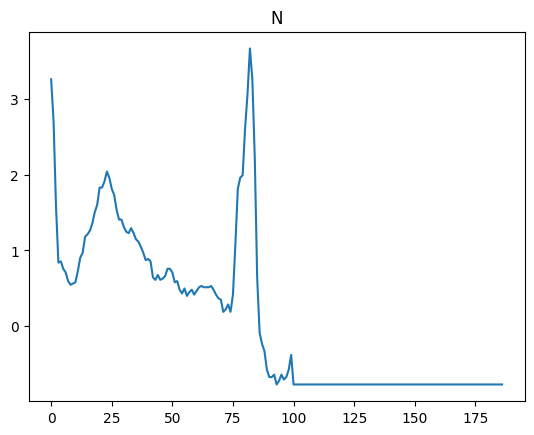

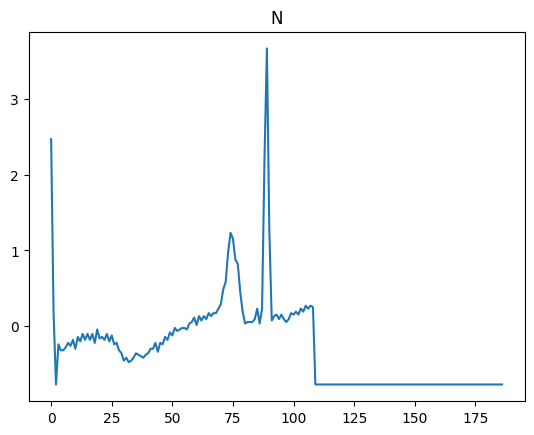

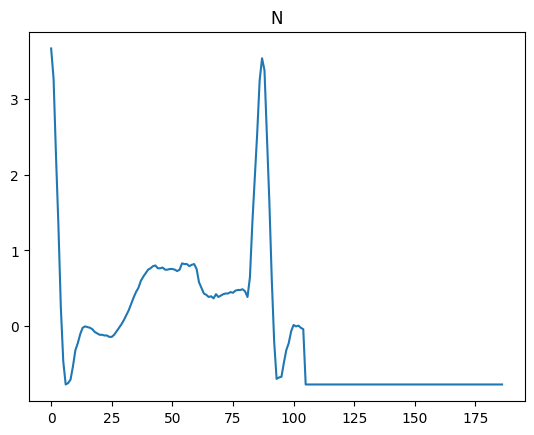

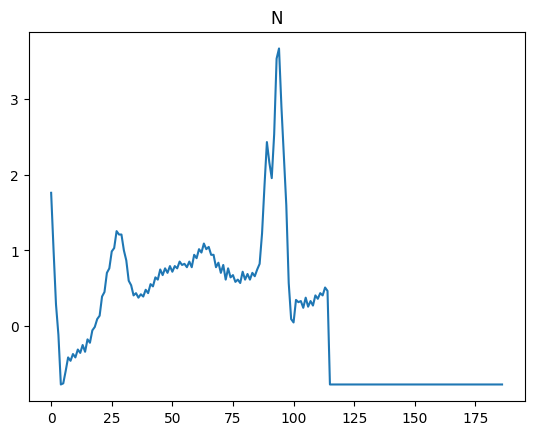

In [60]:
#visualize the first 5 samples
for i in range(5):
    plt.plot(X_test_np[i, 0])
    plt.title(class_names[y_test_np[i, 0]])
    plt.show()

In [61]:
print(f'test mean: {X_test_np.mean():.4f} \t test std: {X_test_np.std():.4f}')

test mean: 0.0000 	 test std: 1.0000


In [62]:
#print the number of samples in each class
for i in range(5):
    print(f'class {i}: {np.sum(y_test_np == i)}')

class 0: 18118
class 1: 556
class 2: 1448
class 3: 162
class 4: 1608


In [63]:
#create a dataset
test_ds = TensorDataset(torch.from_numpy(X_test_np), torch.from_numpy(y_test_np))
test_dl = DataLoader(test_ds, batch_size=hyper_params['bs'], shuffle=False)

In [64]:
#use this cell to load weights from disk
model = get_model().to(device=device)
model.load_state_dict(torch.load('best_model0.99.pt'))

<All keys matched successfully>

### We have a total accuracy of 98% on the test data
#### also we have to pay attention to precision and recall
#### we don't have the numbers we had with the validation set but still it does very well

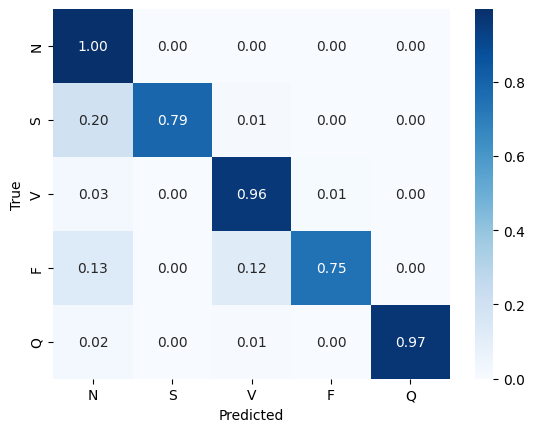

              precision    recall  f1-score   support

           N       0.99      1.00      0.99     18118
           S       0.90      0.79      0.84       556
           V       0.95      0.96      0.96      1448
           F       0.86      0.75      0.80       162
           Q       1.00      0.97      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.94      0.89      0.92     21892
weighted avg       0.98      0.98      0.98     21892



In [65]:
#calculate the sensitivity and specificity for each class using scikit-learn
plot_cm(model, test_dl, class_names)